In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rice, uniform
from scipy import ndimage
import time
import os

In [21]:
# --- 1. SETUP: Paths, Metadata, and Helper Functions ---

IMAGE_DIR = '../images'
TARGET_DIR = '../target_lists'
PARAM_DIR = 'parameter_maps_6x9' # Directory to save/load MLE results

if not os.path.exists(PARAM_DIR):
    os.makedirs(PARAM_DIR)

# --- Metadata for all 24 images ---
image_metadata = [
    # Mission 2: Deployment "Sigismund"
    {'mission': 2, 'pass': 1, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 2, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 3, 'heading': 225, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 4, 'heading': 135, 'deployment': 'Sigismund', 'rfi': 0, 'filename': 'v02_2_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 5, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 2, 'pass': 6, 'heading': 230, 'deployment': 'Sigismund', 'rfi': 1, 'filename': 'v02_2_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 3: Deployment "Karl"
    {'mission': 3, 'pass': 1, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_1_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 2, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 3, 'heading': 225, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 4, 'heading': 135, 'deployment': 'Karl', 'rfi': 0, 'filename': 'v02_3_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 5, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_5_2.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 3, 'pass': 6, 'heading': 230, 'deployment': 'Karl', 'rfi': 1, 'filename': 'v02_3_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 4: Deployment "Fredrik"
    {'mission': 4, 'pass': 1, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 2, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 3, 'heading': 225, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 4, 'heading': 135, 'deployment': 'Fredrik', 'rfi': 0, 'filename': 'v02_4_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 5, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 4, 'pass': 6, 'heading': 230, 'deployment': 'Fredrik', 'rfi': 1, 'filename': 'v02_4_6_1.a.Fbp.RFcorr.Geo.Magn'},
    # Mission 5: Deployment "Adolf-Fredrik"
    {'mission': 5, 'pass': 1, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_1_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 2, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_2_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 3, 'heading': 225, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_3_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 4, 'heading': 135, 'deployment': 'Adolf-Fredrik', 'rfi': 0, 'filename': 'v02_5_4_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 5, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_5_1.a.Fbp.RFcorr.Geo.Magn'},
    {'mission': 5, 'pass': 6, 'heading': 230, 'deployment': 'Adolf-Fredrik', 'rfi': 1, 'filename': 'v02_5_6_1.a.Fbp.RFcorr.Geo.Magn'},
]
epsilon = 1e-9

def load_sar_image(filename, directory, rows=3000, cols=2000):
    filepath = os.path.join(directory, filename)
    image_data = np.fromfile(filepath, dtype='>f4').reshape((rows, cols))
    return image_data

def load_ground_truth_pixels(deployment_name, target_dir):
    target_filename = deployment_name + ".Targets.txt"
    target_filepath = os.path.join(target_dir, target_filename)
    ground_truth_geo = np.loadtxt(target_filepath, usecols=(0, 1))
    Nmax, Emin = 7370488, 1653166
    ground_truth_pixels = []
    for north, east in ground_truth_geo:
        row = int(round(Nmax - north))
        col = int(round(east - Emin))
        ground_truth_pixels.append((row, col))
    return ground_truth_pixels

def evaluate_performance(detection_map, ground_truth_pixels):
    eroded_map = ndimage.binary_erosion(detection_map)
    processed_map = ndimage.binary_dilation(eroded_map, iterations=2)
    labeled_map, num_objects = ndimage.label(processed_map)
    if num_objects == 0:
        return 0.0, 0.0
    detected_centers = ndimage.center_of_mass(processed_map, labeled_map, range(1, num_objects + 1))
    match_radius = 10.0
    true_positives = 0
    unmatched_detections = list(detected_centers)
    num_true_targets = len(ground_truth_pixels)
    for true_target_pos in ground_truth_pixels:
        for i, detected_pos in enumerate(unmatched_detections):
            distance = np.sqrt((true_target_pos[0] - detected_pos[0])**2 + (true_target_pos[1] - detected_pos[1])**2)
            if distance <= match_radius:
                true_positives += 1
                unmatched_detections.pop(i)
                break
    false_positives = len(unmatched_detections)
    image_area_km2 = 6.0
    pd = true_positives / num_true_targets if num_true_targets > 0 else 0.0
    far = false_positives / image_area_km2
    return pd, far

In [22]:
# --- 2. Data Preparation ---
print("--- Data Preparation ---")
surveillance_info = image_metadata[0]
background_stack_info = [img for img in image_metadata if img['heading'] == surveillance_info['heading'] and img['deployment'] != surveillance_info['deployment']]
print(f"Surveillance Image: {surveillance_info['filename']}")
surveillance_image = load_sar_image(surveillance_info['filename'], IMAGE_DIR)
background_images = [load_sar_image(info['filename'], IMAGE_DIR) for info in background_stack_info]
background_stack = np.stack(background_images, axis=0)
ground_truth = load_ground_truth_pixels(surveillance_info['deployment'], TARGET_DIR)
print(f"Loaded {len(ground_truth)} ground truth targets.\n")

--- Data Preparation ---
Surveillance Image: v02_2_1_1.a.Fbp.RFcorr.Geo.Magn
Loaded 25 ground truth targets.



In [23]:
# # --- 3. Rician Background Modeling (Block-Based MLE) ---
# print("--- Rician Background Modeling (Block-Based) ---")
# B_MAP_FILE = os.path.join(PARAM_DIR, 'b_map_block.npy')
# LOC_MAP_FILE = os.path.join(PARAM_DIR, 'loc_map_block.npy')
# SCALE_MAP_FILE = os.path.join(PARAM_DIR, 'scale_map_block.npy')

# if os.path.exists(B_MAP_FILE):
#     print("Loading pre-calculated block-based Rician parameter maps...")
#     b_map = np.load(B_MAP_FILE)
#     loc_map = np.load(LOC_MAP_FILE)
#     scale_map = np.load(SCALE_MAP_FILE)
# else:
#     print("Performing block-based Rician MLE fit. THIS WILL TAKE SEVERAL HOURS.")
#     start_time = time.time()
#     rows, cols = surveillance_image.shape
#     b_map, loc_map, scale_map = np.zeros((3, rows, cols))
    
#     # Define the block size from the paper
#     BLOCK_WIDTH = 6
#     BLOCK_HEIGHT = 9
#     h_half_w = BLOCK_WIDTH // 2
#     h_half_h = BLOCK_HEIGHT // 2
    
#     for r in range(rows):
#         for c in range(cols):
#             # Define the window boundaries, ensuring they don't go out of bounds
#             r_start = max(0, r - h_half_h)
#             r_end = min(rows, r + h_half_h + 1)
#             c_start = max(0, c - h_half_w)
#             c_end = min(cols, c + h_half_w + 1)
            
#             # Extract all samples from the window across all 6 background images
#             window_data = background_stack[:, r_start:r_end, c_start:c_end]
#             samples = window_data.flatten()
            
#             # Fit the Rician model to this large set of samples
#             try:
#                 b, loc, scale = rice.fit(samples, floc=0)
#                 b_map[r, c], loc_map[r, c], scale_map[r, c] = b, loc, scale
#             except Exception as e:
#                 # Fallback for the rare cases where even this might fail
#                 mean = np.mean(samples)
#                 std = np.std(samples)
#                 b_map[r, c] = mean / std if std > 0 else 0
#                 loc_map[r, c] = 0
#                 scale_map[r, c] = std if std > 0 else epsilon

#         if (r + 1) % 50 == 0:
#             elapsed = time.time() - start_time
#             print(f"Processed row {r+1}/{rows}... Time: {elapsed/60:.2f} min.")
            
#     print("Block-based MLE fitting complete. Saving maps to disk...")
#     np.save(B_MAP_FILE, b_map)
#     np.save(LOC_MAP_FILE, loc_map)
#     np.save(SCALE_MAP_FILE, scale_map)

# print("Background model is ready.\n")

In [24]:
# --- 3. Rician Background Modeling (FIXED WINDOWS) ---
print("--- Rician Background Modeling (Fixed, Non-Overlapping Windows) ---")
B_MAP_FILE = os.path.join(PARAM_DIR, 'b_map_fixed.npy')
LOC_MAP_FILE = os.path.join(PARAM_DIR, 'loc_map_fixed.npy')
SCALE_MAP_FILE = os.path.join(PARAM_DIR, 'scale_map_fixed.npy')

if os.path.exists(B_MAP_FILE):
    print("Loading pre-calculated fixed-window Rician parameter maps...")
    b_map = np.load(B_MAP_FILE)
    loc_map = np.load(LOC_MAP_FILE)
    scale_map = np.load(SCALE_MAP_FILE)
else:
    print("Performing fixed-window Rician MLE fit. This will be faster than sliding window.")
    start_time = time.time()
    rows, cols = surveillance_image.shape
    b_map, loc_map, scale_map = np.zeros((3, rows, cols))
    
    BLOCK_WIDTH = 6
    BLOCK_HEIGHT = 9
    
    # Iterate over the image in fixed, non-overlapping blocks
    for r_start in range(0, rows, BLOCK_HEIGHT):
        for c_start in range(0, cols, BLOCK_WIDTH):
            # Define the block boundaries
            r_end = min(r_start + BLOCK_HEIGHT, rows)
            c_end = min(c_start + BLOCK_WIDTH, cols)
            
            # Extract all samples from the block across all 6 background images
            block_data = background_stack[:, r_start:r_end, c_start:c_end]
            samples = block_data.flatten()
            
            # Fit one Rician model for the entire block
            try:
                b, loc, scale = rice.fit(samples, floc=0)
            except Exception as e:
                # Fallback if fit fails
                mean = np.mean(samples)
                std = np.std(samples)
                b = mean / std if std > 0 else 0
                loc = 0
                scale = std if std > 0 else epsilon

            # Assign the SAME parameters to ALL pixels within this block
            b_map[r_start:r_end, c_start:c_end] = b
            loc_map[r_start:r_end, c_start:c_end] = loc
            scale_map[r_start:r_end, c_start:c_end] = scale

        if (r_start + BLOCK_HEIGHT) % 100 < BLOCK_HEIGHT:
            elapsed = time.time() - start_time
            print(f"Processed up to row {r_start + BLOCK_HEIGHT}/{rows}... Time: {elapsed/60:.2f} min.")
            
    print("Fixed-window MLE fitting complete. Saving maps to disk...")
    np.save(B_MAP_FILE, b_map)
    np.save(LOC_MAP_FILE, loc_map)
    np.save(SCALE_MAP_FILE, scale_map)

print("Background model is ready.\n")

--- Rician Background Modeling (Fixed, Non-Overlapping Windows) ---
Loading pre-calculated fixed-window Rician parameter maps...
Background model is ready.



In [25]:
# --- 4. ROC Curve Generation ---
print("--- ROC Curve Generation ---")
pfa_thresholds = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
tau_thresholds = [1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7]
npcbs_results = []
npc_results = []

# --- Method 1: NPCBS ---
print("Running NPCBS method...")
for p_fa in pfa_thresholds:
    detection_threshold = 1 - p_fa
    cdf_values = rice.cdf(surveillance_image, b_map, loc=loc_map, scale=(scale_map + epsilon))
    detection_map = cdf_values >= detection_threshold
    pd, far = evaluate_performance(detection_map, ground_truth)
    npcbs_results.append((far, pd))
    print(f"  P_FA={p_fa:.1e} -> Pd={pd:.2%}, FAR={far:.2f}")

# --- Method 2: NPC ---
print("\nRunning NPC method...")
a_min, a_max = 0.4, np.max(surveillance_image)
p_background = rice.pdf(surveillance_image, b_map, loc=loc_map, scale=(scale_map + epsilon))
p_target = uniform.pdf(surveillance_image, loc=a_min, scale=(a_max - a_min))
likelihood_ratio = p_target / (p_background + epsilon)
for tau in tau_thresholds:
    detection_map = likelihood_ratio >= tau
    pd, far = evaluate_performance(detection_map, ground_truth)
    npc_results.append((far, pd))
    print(f"  Tau={tau:.0e} -> Pd={pd:.2%}, FAR={far:.2f}")

--- ROC Curve Generation ---
Running NPCBS method...
  P_FA=1.0e-02 -> Pd=100.00%, FAR=225.00
  P_FA=5.0e-03 -> Pd=100.00%, FAR=84.83
  P_FA=1.0e-03 -> Pd=100.00%, FAR=11.17
  P_FA=5.0e-04 -> Pd=100.00%, FAR=4.33
  P_FA=1.0e-04 -> Pd=100.00%, FAR=0.33
  P_FA=5.0e-05 -> Pd=100.00%, FAR=0.17
  P_FA=1.0e-05 -> Pd=100.00%, FAR=0.17
  P_FA=5.0e-06 -> Pd=100.00%, FAR=0.33
  P_FA=1.0e-06 -> Pd=100.00%, FAR=0.67

Running NPC method...
  Tau=1e+00 -> Pd=100.00%, FAR=276.33
  Tau=1e+01 -> Pd=100.00%, FAR=10.33
  Tau=1e+02 -> Pd=100.00%, FAR=0.83
  Tau=1e+03 -> Pd=100.00%, FAR=0.17
  Tau=1e+04 -> Pd=100.00%, FAR=0.67
  Tau=1e+05 -> Pd=100.00%, FAR=1.00
  Tau=1e+06 -> Pd=100.00%, FAR=1.17
  Tau=1e+07 -> Pd=100.00%, FAR=1.00



--- Plotting ROC Curve ---


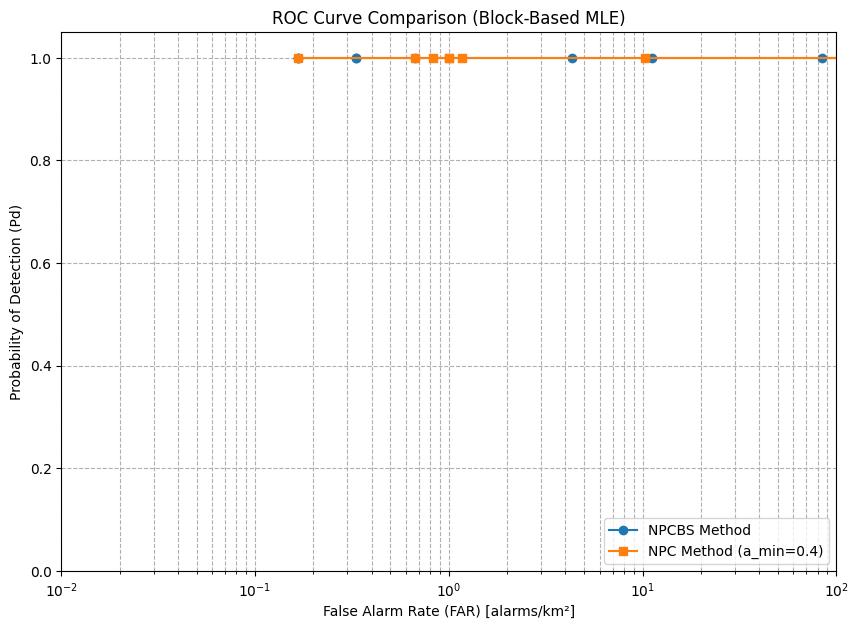

In [26]:
# --- 5. Plotting the ROC Curve ---
print("\n--- Plotting ROC Curve ---")
plt.figure(figsize=(10, 7))
npcbs_results.sort()
npc_results.sort()
if npcbs_results:
    npcbs_far, npcbs_pd = zip(*npcbs_results)
    plt.plot(npcbs_far, npcbs_pd, 'o-', label='NPCBS Method')
if npc_results:
    npc_far, npc_pd = zip(*npc_results)
    plt.plot(npc_far, npc_pd, 's-', label='NPC Method (a_min=0.4)')

plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.xlabel('False Alarm Rate (FAR) [alarms/km²]')
plt.ylabel('Probability of Detection (Pd)')
plt.title('ROC Curve Comparison (Block-Based MLE)')
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.xlim(1e-2, 1e2)
plt.show()